In [17]:
from numpy.random import seed
from tensorflow.random import set_seed
import random

seed(1)
set_seed(1)
random.seed(1)


import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import History 

from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from utils import  get_features, k_fold


### Read data & preprocessing
- Read data in
- Engineer features for train & unseen data
- Get scaling parameters from train data only
- Scale train and test data using same scale

In [14]:
df = pd.read_csv('../data/Data_A.csv', header=None)
test_data = pd.read_csv('../data/Data_B_nolabels.csv', header=None)

columns=['midprice_up','ss_lob_1_p','ss_lob_1_v','bs_lob_1_p','bs_lob_1_v','ss_lob_2_p','ss_lob_2_v',
'bs_lob_2_p','bs_lob_2_v','ss_lob_3_p','ss_lob_3_v','bs_lob_3_p','bs_lob_3_v','ss_lob_4_p','ss_lob_4_v',
'bs_lob_4_p','bs_lob_4_v','c1','c2','c3','c4','c5']

df.columns = columns
test_data.columns = columns[1:]

price_cols = ['ss_lob_1_p','bs_lob_1_p','ss_lob_2_p','bs_lob_2_p','ss_lob_3_p','bs_lob_3_p','ss_lob_4_p','bs_lob_4_p']
vol_cols = ['ss_lob_1_v','bs_lob_1_v','ss_lob_2_v','bs_lob_2_v','ss_lob_3_v','bs_lob_3_v','ss_lob_4_v','bs_lob_4_v']
prev_mid_m_cols = ['c1', 'c2', 'c3', 'c4', 'c5']

# engineer features
df, engineered_cols = get_features(df)
X_test, engineered_cols = get_features(test_data)

# do train test split
X_train = df.drop(columns='midprice_up')
y_train = df['midprice_up']



means = X_train[price_cols+vol_cols+engineered_cols].mean(axis=0)
stds = X_train[price_cols+vol_cols+engineered_cols].std(axis=0)

def transform(df, means, stds):
    return (df-means)/stds

X_train[price_cols+vol_cols+engineered_cols] = transform(X_train[price_cols+vol_cols+engineered_cols], means, stds)
X_test[price_cols+vol_cols+engineered_cols] = transform(X_test[price_cols+vol_cols+engineered_cols], means, stds)



We use the optimal hyperparamers found in `src/parameter_tune.ipynb`

- Epochs = 20
- batch_size = 50
- $\eta$ = 0.001
- Optimizer = Adam($\eta$=0.001)

We perform 5 fold CV one last time to sense check that the final model aligns with the experiments done in parameter tuning.

Next we train the model on all the training data, and predict the unlabeled data


Time taken: 528.9s


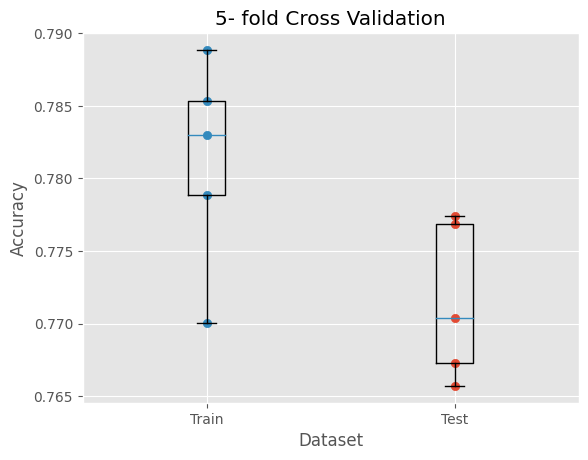

Epoch 1/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.4405 - accuracy: 0.7841
Epoch 2/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.4400 - accuracy: 0.7844
Epoch 3/20
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4394 - accuracy: 0.7854
Epoch 4/20
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4396 - accuracy: 0.7854
Epoch 5/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.4389 - accuracy: 0.7849
Epoch 6/20
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4387 - accuracy: 0.7852
Epoch 7/20
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4384 - accuracy: 0.7862
Epoch 8/20
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4382 - accuracy: 0.7854
Epoch 9/20
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4376 - accuracy: 0.7861
Epoch 10/20
2000/2000 [==============================] - 8s 4ms/step - loss: 0.437

In [18]:
eta = 0.001
batch_size=50
optimizer=Adam(eta)
epochs=20



history = History()
model = keras.Sequential([
    InputLayer(input_shape=(len(X_train.columns))),
    Dense(units=100, activation='elu'),
    Dense(units=50, activation='elu'),
    Dense(units=20, activation='elu'),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# k fold CV
k_fold(model=model, X=X_train, Y=y_train, batch_size=batch_size, epochs=epochs, history=History()); plt.show()


# Train model on all training data
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[History()])


y_train_pred = model.predict(X_train, verbose=0)
y_train_pred = (y_train_pred>0.5).astype(int)
train_accuracy = accuracy_score(y_train_pred.flatten(), y_train.to_numpy().flatten())

print(f"{train_accuracy=}")

y_test_pred = model.predict(X_test, verbose=0)
y_test_pred = (y_test_pred>0.5).astype(int)



Save predictions to output file

In [16]:
for cid_name in ['02274149_Coxon', '01075416_McGreevy', '02306375_MorenodeVega']:
    pd.Series(y_test_pred.flatten()).to_csv(f'./predictions/{cid_name}.txt', index=False, header=False)
